# Итоговое задание по курсу АОТ

### Язык программирования python3 (задание E, пункт 2: тематическая классификация на основе векторной модели текста)

***Импортируем все необходимые модули для парсинга текстов, извлечения векторов из текста, классификаторы и метрики.***

In [136]:
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import pandas as pd
import numpy as np
import re

***Вынесем нерелевантные токены в лист.***

In [90]:
ignore_symbs = [',', '-', ':', '!', ';', '(', ')', '–', '"', '{', '}', '[', ']', '.', '?', '@',
                '<', '>', '|', '*', '...']

***Воспользуемся размеченной выборкой текстов из модуля scikit-learn.datasets. Модуль содержит размеченные выборки текстов на 20 тематик. Выберем две темы для простоты визуализации: компьютерное железо и религия . Запишем эти сырые тексты в два листа – train и test. ***

In [91]:
cats=['comp.sys.mac.hardware', 'soc.religion.christian']
train = fetch_20newsgroups(subset='train', categories=cats, remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', categories=cats, remove=('headers', 'footers', 'quotes'))
train_target = train.target
test_target = test.target

***Посмотрим на первые тексты в train и test выборках.***

In [29]:
print(train.data[0])


I haven't followed whatever discussion there may have been on these
people, but I feel that C. S. Lewis is an excellent apologist and I
see no reason for embarrassment.  If you think that errors and flawed
arguments are a reason for dismissing a thinker, you must dismiss
nearly every thinker from Descartes to Kant; any philosophy course
will introduce you to their weaknesses.  
 
  The above also expresses a rather odd sense

I said nothing about "the masses."  However comparing "the masses" in
our day and in Aquinas' day really *is* odd.  Read Ortega y Gasset on
this.

I'm talking about the familiar experience of arguing all night and
winning on logic and evidence, only to discover your opponent to be
unaware, even intuitively, of things like entailment (let alone
pragmatics).  (I am assuming that both parties are college graduates
or better...)  Myself, I don't bother any more.

Ken


In [30]:
print(test.data[0])

Hi everyone,

I'm trying to find my way to God, but find it difficult as I can't hear
God talking to me, letting me know that he exists and is with me and
that he knows me, and I feel that I can't possibly get to know him until
he does. Maybe he _is_ talking to me but I just don't know or understand
how to listen.

Some Christians tell me that (in their opinion) the only way to find God
is to take a plunge and commit your life to him, and you will discover.
This idea of diving into the totally unknown is a little bit
frightening, but I have a few questions.

1) How do you actually commit yourself? If I just say, "OK God, her you
go, I'm committing my life to you", I wouldn't really feel that he'd
listened - at least, I couldn't be sure that he had. So how does one (or
how did you) commit oneself to God?

2) In committing myself in this way, what do I have to forfeit of my
current life? What can I no longer do? I feel that I'm as 'good' as many
Christians, and I try to uphold the idea o

***Теперь необходимо выбросить из списка токенов знаки препинания, привести слова к нормальной форме и соединить их обратно в текст. Класс word_tokenize из модуля nltk разбивает текст на токены и возвращает лист. Далее лист токенов фильтруется, а класс WordNetLemmatizer приводит слова к нормальной форме. На выходе получаем листы текстов, в которых все слова приведены к нормальной форме. Здесь не используется список стоп-слов, так как в векторизаторах scikit-learn встроен фильтр стоп-слов. ***

In [92]:
train_normal = []
test_normal = []
for text in train.data:
    tokens = nltk.word_tokenize(text)
    tokens = list(filter(lambda x: x not in ignore_symbs, tokens))
    wnl = WordNetLemmatizer()
    normal_form_list = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] 
                   else wnl.lemmatize(i) for i,j in pos_tag(tokens)]
    normal_form = ' '.join(normal_form_list)
    normal_form = re.sub(r'\d+', '', normal_form.replace('*', ''))
    train_normal.append(normal_form)
    
for text in test.data:
    tokens = nltk.word_tokenize(text)
    tokens = list(filter(lambda x: x not in ignore_symbs, tokens))
    wnl = WordNetLemmatizer()
    normal_form_list = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] 
                   else wnl.lemmatize(i) for i,j in pos_tag(tokens)]
    normal_form = ' '.join(normal_form_list)
    normal_form = re.sub(r'\d+', '', normal_form.replace('*', ''))
    test_normal.append(normal_form)

*** Попробуем две векторные модели текста ***

*** I. Bag of words ***

In [142]:
vectorizer = CountVectorizer(analyzer='word')
train_vectorized = vectorizer.fit_transform(train_normal)
test_vectorized = vectorizer.transform(test_normal)

Построим несколько моделей и посмотрим, как они себя покажут на тестовом множестве. Зададим итератор разбиений для кросс-валидации на 10 фолдов, зададим список моделей и будем искать оптимальные гиперпараметры по сетке.

In [143]:
cross_validator = StratifiedKFold(y=train_target, n_folds=10, shuffle=True, random_state=0)
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
models_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
best_score_bow = 0
param_grids = [{'C': [10**x for x in range(-3, 2)], 'class_weight': [None, 'balanced'], 'random_state': [0]},
               {'n_estimators': [100, 200, 300], 'max_depth': [5, 8, None],
                'class_weight': [None, 'balanced'], 'random_state': [0]},
                {'max_depth': [3], 'n_estimators': [100, 150],
                 'random_state': [0]}]
for clf, params, name in zip(models, param_grids, models_names):
    gs = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=cross_validator)
    gs.fit(train_vectorized.toarray(), train_target)
    print('For {} the score is {} with parameters {}'.format(name, gs.best_score_, gs.best_params_))
    if gs.best_score_ > best_score_bow:
        best_score_bow = gs.best_score_
        best_estimator_bow = gs.best_estimator_

print('The best estimator is {}\nwith accuracy = {}'.format(best_estimator_bow, best_score_bow))

For Logistic Regression the score is 0.9507221750212405 with parameters {'random_state': 0, 'C': 10, 'class_weight': None}
For Random Forest the score is 0.9252336448598131 with parameters {'n_estimators': 300, 'random_state': 0, 'max_depth': None, 'class_weight': 'balanced'}
For Gradient Boosting the score is 0.9362786745964317 with parameters {'n_estimators': 150, 'random_state': 0, 'max_depth': 3}
The best estimator is LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
with accuracy = 0.9507221750212405


*** Среднее по валидационным разбиениям показывает хорошие результаты на всех алгоритмах, выберем логистическую регрессию, как алгоритм с самым высоким средним значением accuracy. Проверим теперь этот алгоритм на тестовой выборке. ***

             precision    recall  f1-score   support

          0       0.92      0.97      0.94       385
          1       0.97      0.91      0.94       398

avg / total       0.94      0.94      0.94       783



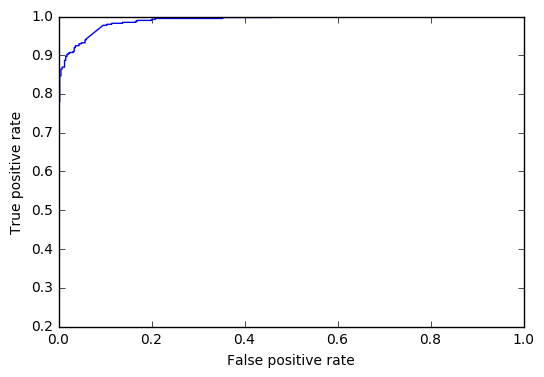

Area under ROC curve score = 0.9900345885270507
Accuracy = 0.9399744572158365


In [146]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
pred = best_estimator_bow.predict_proba(test_vectorized.toarray())[:,1]
print(classification_report(test_target, best_estimator_bow.predict(test_vectorized.toarray())))
fpr, tpr, thresholds = metrics.roc_curve(test_target, pred)
acc = metrics.accuracy_score(y_pred=best_estimator_bow.predict(test_vectorized.toarray()), y_true=test_target)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
print('Area under ROC curve score = {}'.format(roc_auc_score(test_target, pred)))
print('Accuracy = {}'.format(acc))

*** II. a) TF-IDF ***

In [147]:
vectorizer_tfidf = TfidfVectorizer()
train_tfidf = vectorizer_tfidf.fit_transform(train_normal)
test_tfidf = vectorizer_tfidf.transform(test_normal)

Повторим шаг с выбором моделей

In [148]:
cross_validator = StratifiedKFold(y=train_target, n_folds=10, shuffle=True, random_state=0)
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
models_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
best_score_tfidf = 0
param_grids = [{'C': [10**x for x in range(-3, 2)], 'class_weight': [None, 'balanced'], 'random_state': [1]},
               {'n_estimators': [100, 200, 300], 'max_depth': [5, 8, None],
                'class_weight': [None, 'balanced'], 'random_state': [0]},
                {'max_depth': [3], 'n_estimators': [100, 150],
                 'random_state': [0]}]
for clf, params, name in zip(models, param_grids, models_names):
    gs = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=cross_validator)
    gs.fit(train_tfidf.toarray(), train_target)
    if gs.best_score_ > best_score_tfidf:
        best_score_tfidf = gs.best_score_
        best_estimator_tfidf = gs.best_estimator_
    print('For {} the score is {} with parameters {}'.format(name, best_score_tfidf, gs.best_params_))


print('The best estimator is {}\nwith accuracy = {}'.format(best_estimator_tfidf, best_score_tfidf))

For Logistic Regression the score is 0.9668649107901445 with parameters {'random_state': 1, 'C': 10, 'class_weight': None}
For Random Forest the score is 0.9668649107901445 with parameters {'n_estimators': 100, 'random_state': 0, 'max_depth': None, 'class_weight': 'balanced'}
For Gradient Boosting the score is 0.9668649107901445 with parameters {'n_estimators': 150, 'random_state': 0, 'max_depth': 3}
The best estimator is LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
with accuracy = 0.9668649107901445


             precision    recall  f1-score   support

          0       0.94      0.98      0.96       385
          1       0.98      0.94      0.96       398

avg / total       0.96      0.96      0.96       783



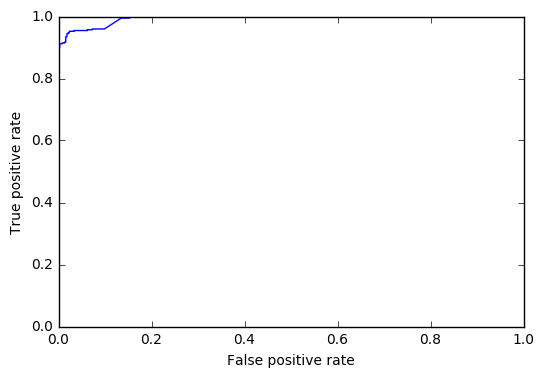

Area under ROC curve score = 0.9931149252757294
Accuracy = 0.9616858237547893


In [149]:
pred = best_estimator_tfidf.predict_proba(test_tfidf.toarray())[:,1]
print(classification_report(test_target, best_estimator_tfidf.predict(test_tfidf.toarray())))
fpr, tpr, thresholds = metrics.roc_curve(test_target, pred)
acc = metrics.accuracy_score(y_pred=best_estimator_tfidf.predict(test_tfidf.toarray()), y_true=test_target)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
print('Area under ROC curve score = {}'.format(roc_auc_score(test_target, pred)))
print('Accuracy = {}'.format(acc))

*** Теперь проверим написанные вручную алгоритмы: трехслойный перцептрон и логистическую регрессию ***

In [161]:
# Класс, реализующий логистическую регрессию с L2 регуляризацией

class LogisticRegression_m(object):

    def __init__(self, eta=0.1, C=0, n_iter=100, method='batch', verbose=False):
        """ Конструктор. Параметры:
            eta - learning rate, определяет величину шага в сторону антиградиента, вещественное число
            C - параметр L2 регуляризации, вещественное число
            n_iter - число итераций по данным, целое число
            method - возможные значения: batch, mini-batch, stoch. Тип градиентного спуска.
            verbose - использовать для отладки и мониторинга сходимости """
        self.eta_ = eta
        self.n_iter_ = n_iter
        self.C_ = C
        self.method_ = method

    def fit(self, X, y):
        """ Функция обучения регрессии. Параметры:
            X - numpy array-like массив. В строках наблюдения, в столбцах пременные
            y - вектор ответов """
        self.all_w_ = np.zeros((np.unique(y).size, X.shape[1] + 1))
        self.num_labels = np.unique(y).size

        if self.method_ == 'batch':
            self._batch_grad(X, y)
        if self.method_ == 'stoch':
            self._stoch_grad(X, y)
        if self.method_ == 'mini-batch':
            self._minibatch_grad(X, y)
        return self

    def _batch_grad(self, X, y):
        """ Реализация т.н. batch градиентного спуска. Функция n_iter раз проходит по всему датасету,
            каждый раз вызывая один шаг спуска """
        for i in range(self.n_iter_):
            self._batch_step(X, y)

    def _batch_step(self, X, y):
        """ Шаг batch градиентного спуска """
        self._one_v_rest(X, y)

    def _one_v_rest(self, X, y):
        """ Реализация поддержки многоклассовой задачи методом one vs rest """
        for c in np.unique(y):
            y_ovr = np.where(y == c, 1, 0)
            error = y_ovr - self.sigmoid(X, c)
            self.all_w_[c, 0] += self.eta_ * error.sum() - self.eta_ * \
                self.C_ * self.all_w_[c, 0]
            self.all_w_[c, 1:] += self.eta_ * X.T @ error - \
                self.eta_ * self.C_ * self.all_w_[c, 1:]

    def _stoch_grad(self, X, y):
        """ Реализация стохастического градиентного спуска. Рекомендуется при большом количестве данных. """
        for i in range(self.n_iter_):
            self._stoch_step(X, y)

    def _stoch_step(self, X, y):
        """ Реализация шага стохастического градиентного спуска """
        rand_indices = np.random.permutation(y.size)
        rand_choice = np.random.randint(0, y.size)
        sample = X[rand_indices, :][rand_choice, :]

        error = y[rand_indices][rand_choice] - self.sigmoid(sample)
        self.w_[0] += self.eta_ * error - self.eta_ * self.C_ * self.w_[0]
        self.w_[1:] += self.eta_ * sample * \
            error - self.eta_ * self.C_ * self.w_[1:]
        self.errors_.append(self.logit_loss(
            sample, y[rand_indices][rand_choice]))

    def sigmoid(self, X, c):
        """ Функция связи логистической регрессии """
        z = self.net_input(X, c)
        return (1 / (1 + np.exp(-z)))

    def net_input(self, X, c):
        """ Скалярное произведение полученных после обучения весов и переменных наблюдения """
        return (X @ self.all_w_[c, 1:] + self.all_w_[c, 0])

    def logit_loss(self, X, y):
        """ Кросс-энтропия, целевая функция """
        return -(y * np.log(self.sigmoid(X)) + (1 - y) *
                 np.log(1 - self.sigmoid(X))).sum()

    def predict(self, X):
        """ Возвращает ответы """
        probas = self._predict_one_v_rest(X)
        return np.argmax(probas, axis=1)

    def predict_proba(self, X):
        """ Возвращает вероятности ответов """
        return self._predict_one_v_rest(X)

    def _predict_one_v_rest(self, X):
        """ Реализация для поддержки многоклассовой задачи методом one vs rest """
        probas = np.zeros((X.shape[0], self.num_labels))
        for c in range(self.num_labels):
            probas[:, c] = self.sigmoid(X, c)
        return probas

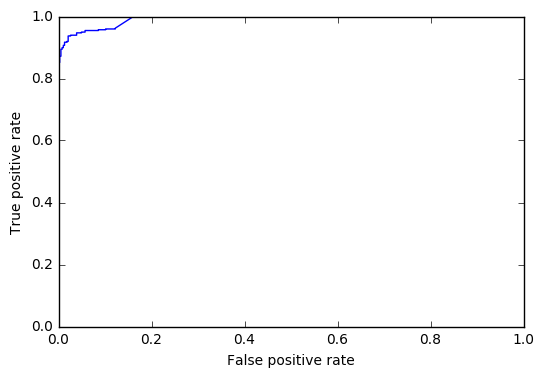

Area under ROC curve score = 0.9914311818834431
Accuracy = 0.9501915708812261


In [163]:
lrm = LogisticRegression_m(C=0.1, n_iter=100)
lrm.fit(train_tfidf, train_target)
predi = lrm.predict_proba(test_tfidf)
fpr, tpr, thresholds = metrics.roc_curve(test_target, predi[:, 1])
acc = metrics.accuracy_score(y_pred=lrm.predict(test_tfidf.toarray()), y_true=test_target)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
print('Area under ROC curve score = {}'.format(roc_auc_score(test_target, predi[:,1])))
print('Accuracy = {}'.format(acc))

In [169]:
# import numpy as np
from collections import OrderedDict


class BagOfWordsVectorizer(object):

    def __init__(self):
        self.dictionary = OrderedDict()
        self.max_features = max_features

    def fit(self, X):
        X_in = np.array(X)
        X_in = self._make_dictionary(X_in)
        self._vectorize(X_in)
        return self

    def _make_dictionary(self, X):
        uniques = np.unique(X)
        self.dictionary.update(zip(uniques, np.zeros((1, uniques.size))))
        return X

    def _vectorize(self, X):
        X_vectorized = np.zeros((X.shape[0], X.shape[1]))
        for num, row in enumerate(X):
            row_dict = self.dictionary
            for val in row:
                if row_dict.get(val) is None:
                    continue
                else:
                    row_dict[val] += 1

            X_vectorized[num, :] = np.array(list(row_dict.values()))

        return X_vectorized

    def transform(self, X):
        return self._vectorize(X)

    def get_words(self):
        return list(self.dictionary.keys())


class FinalHWData(object):

    def __init__(self, categories, remove):
        self.categories = categories
        self.remove = remove
        self._init_data()

    def _init_data(self):
        self.train = fetch_20newsgroups(subset='train', categories=cats,
                                        remove=('headers', 'footers', 'quotes'))
        self.test = fetch_20newsgroups(subset='test', categories=cats,
                                       remove=('headers', 'footers', 'quotes'))
        self.train_target = self.train.target
        self.test_target = self.test.target

    def get_data(self, kind):
        if kind.lower() == 'test':
            return self.test.data
        elif kind.lower() == 'train':
            return self.train.data
    
    def get_target(self, kind):
        if kind.lower() == 'test':
            return self.test.target
        elif kind.lower() == 'train':
            return self.train.target


class DataPreparator(object):

    def __init__(self):
        self.train_normal = []
        self.test_normal = []

    def normalize(self, train, test, stop_words):
        for text in train:
            tokens = nltk.word_tokenize(text)
            tokens = list(filter(lambda x: x not in stop_words, tokens))
            wnl = WordNetLemmatizer()
            normal_form_list = [wnl.lemmatize(i, j[0].lower()) if j[0].lower() in ['a', 'n', 'v']
                                else wnl.lemmatize(i) for i, j in pos_tag(tokens)]
            normal_form = ' '.join(normal_form_list)
            normal_form = re.sub(r'\d+', '', normal_form.replace('*', ''))
            self.train_normal.append(normal_form)

        for text in test:
            tokens = nltk.word_tokenize(text)
            tokens = list(filter(lambda x: x not in stop_words, tokens))
            wnl = WordNetLemmatizer()
            normal_form_list = [wnl.lemmatize(i, j[0].lower()) if j[0].lower() in ['a', 'n', 'v']
                                else wnl.lemmatize(i) for i, j in pos_tag(tokens)]
            normal_form = ' '.join(normal_form_list)
            normal_form = re.sub(r'\d+', '', normal_form.replace('*', ''))
            self.test_normal.append(normal_form)

    def get_data(self, kind):
        if kind.lower() == 'train':
            return self.train_normal
        elif kind.lower() == 'test':
            return self.test_normal


class ModelBuilder(object):

    def __init__(self, cv_folds, models, models_names, param_grids):
        self.cv_folds = cv_folds
        self.models = models
        self.models_names = models_names
        self.param_grids = param_grids

    def fit(self, train, target):
        cross_validator = StratifiedKFold(
            y=target, n_folds=self.cv_folds, shuffle=True, random_state=0)
        best_score = 0
        for clf, params, name in zip(self.models, self.param_grids, self.models_names):
            gs = GridSearchCV(estimator=clf, param_grid=params,
                              scoring='accuracy', cv=cross_validator)
            gs.fit(train.toarray(), target)
            print('For {} the score is {} with parameters {}'.format(
                name, gs.best_score_, gs.best_params_))
            if gs.best_score_ > best_score:
                best_score = gs.best_score_
                best_estimator = gs.best_estimator_
        self.estimator = best_estimator
        print('The best estimator is {}\nwith accuracy = {}'.format(
            best_estimator, best_score))

    def test_and_report(self, roc_curve, report, test, target):
        pred = self.estimator.predict_proba(test.toarray())[:, 1]
        print(classification_report(target, self.estimator.predict(test.toarray())))
        fpr, tpr, thresholds = metrics.roc_curve(target, pred)
        acc = metrics.accuracy(y_pred=self.estimator.predict(
            test.toarray()), y_true=target)
        plt.plot(fpr, tpr)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.show()
        print('Area under ROC curve score = {}'.format(
            roc_auc_score(target, pred)))
        print('Accuracy = {}'.format(acc))


In [170]:
data_handle = FinalHWData(categories=cats, remove=('headers', 'footers', 'quotes'))
preparator_handle = DataPreparator()
preparator_handle.normalize(train=data_handle.get_data(kind='train'),
                            test=data_handle.get_data(kind='test'),
                            stop_words=ignore_symbs)
builder = ModelBuilder(cv_folds=10, models=models[:3], models_names=models_names[:3], param_grids=param_grids[:3])
vec = CountVectorizer(analyzer='word')
tr_vec= vec.fit_transform(preparator_handle.get_data(kind='train'))
te_vec = vec.transform(preparator_handle.get_data(kind='test'))
builder.fit(train=tr_vec, target=data_handle.get_target(kind='train'))
builder.test_and_report(test=te_vec, target=data_handle.get_target(kind='test'))

For Logistic Regression the score is 0.9507221750212405 with parameters {'random_state': 1, 'C': 10, 'class_weight': None}
For Random Forest the score is 0.9252336448598131 with parameters {'n_estimators': 300, 'random_state': 0, 'max_depth': None, 'class_weight': 'balanced'}


KeyboardInterrupt: 